In [ ]:
import torch
import soundfile as sf
import numpy as np
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

/home/maditya/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-23 09:55:51.011380: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 09:55:51.018953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740284751.027881  129394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740284751.030554  129394 cuda_blas.cc:1418] Unable to

### Testing to see how embeddings of Wav2Vec2 look :-

In [ ]:
# 1. Load pretrained Wav2Vec2 (frozen by default if we're just doing inference)
model_name = "facebook/wav2vec2-base-960h"  # or any other pretrained checkpoint
model = Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

# Put model in eval mode (no gradients)
model.eval()

# 2. Load a single audio file (16kHz, mono)
audio_file = "/home/maditya/Desktop/Front Era/Other/Datasets/Cry/cry_01.wav"
waveform, sample_rate = sf.read(audio_file)

# If sample_rate != 16000, you need to resample (e.g., via librosa or sox).
# But let's assume it's already 16kHz.

# 3. Convert waveform to the correct format for Wav2Vec2
# feature_extractor => normalizes & creates PyTorch tensors
inputs = feature_extractor(waveform, sampling_rate=sample_rate, return_tensors="pt")

# 4. Forward pass through Wav2Vec2 to get hidden states (embeddings)
with torch.no_grad():
    outputs = model(**inputs)
    # outputs.last_hidden_state is shape (batch_size, seq_length, hidden_size)

# For a single audio file => batch_size=1
last_hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_size)

# 5. You can either save the entire sequence or do a mean-pool
#    a) Entire sequence => shape (seq_len, hidden_size)
embeddings_seq = last_hidden_states[0].cpu().numpy()  # remove batch dim

#    b) Mean pool => single vector of shape (hidden_size,)
embedding_mean = embeddings_seq.mean(axis=0)

# 6. Save to .npy
np.save("wav2vec2_seq_embeddings.npy", embeddings_seq)    # entire sequence
np.save("wav2vec2_mean_embedding.npy", embedding_mean)     # mean-pooled vector

print("✅ Embeddings saved successfully!")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Embeddings saved successfully!


In [ ]:
print(embeddings_seq.shape)
print(embedding_mean.shape)

(346, 768)
(768,)


# Prepare the Data
Steps to perform :-
Right now we have a Final_Datadet_with_aug folder with 3 subfolders and a CSV file
* Get the embeddings per folder and create a CSV file
* Merge the embeddings into one CSV file
* Encode the labels

In [ ]:
import os
import numpy as np
import pandas as pd
import soundfile as sf
import torch
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor

In [ ]:
##########################################
# 1) Load Pretrained Wav2Vec2 (Frozen)
##########################################
model_name = "facebook/wav2vec2-base-960h"
model = Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

model.eval()  # Inference mode
model.to("cpu")  # or "cuda" if you have a GPU

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [ ]:
##########################################
# 2) Define Paths
##########################################
input_dir = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/Final_Dataset_with_aug"
csv_file = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/final_dataset_with_aug.csv"
csv_path = os.path.join(input_dir, csv_file)

# Folder to save mean-pooled embeddings
output_dir = "wav2vec2_mean_embeddings"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
##########################################
# 3) Read CSV (filename, label)
##########################################
df = pd.read_csv(csv_path)  # Must contain at least 'filename' and 'label' columns

In [ ]:
##########################################
# 4) Function to get Mean-Pooled Embedding
##########################################
def get_mean_wav2vec2_embedding(wav_path):
    """
    Loads an audio file (16kHz), extracts Wav2Vec2 embeddings, and returns mean-pooled vector.
    """
    # Load audio (assume 16kHz mono). If not 16kHz, resample externally or use librosa.
    waveform, sr = sf.read(wav_path)
    if sr != 16000:
        raise ValueError(f"Sample rate {sr} != 16000. Please resample before calling this function.")

    # Convert audio to correct format for the feature extractor
    inputs = feature_extractor(waveform, sampling_rate=sr, return_tensors="pt")

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)

    # outputs.last_hidden_state: (batch_size=1, seq_length, hidden_size)
    hidden_states = outputs.last_hidden_state.squeeze(0)  # (seq_length, hidden_size)

    # Mean pooling over time (seq_length)
    mean_embedding = hidden_states.mean(dim=0).cpu().numpy()  # shape: (hidden_size,)

    return mean_embedding

In [ ]:
df.head()

,filename,label
0,cry_154_aug.wav,cry
1,normal_1759_aug.wav,normal
2,scream_684.wav,scream
3,cry_918.wav,cry
4,scream_119_aug.wav,scream


In [ ]:
##########################################
# 5) Extract Embeddings & Save
##########################################
metadata = []  # Will store rows: [filename, embedding_file, label]

for idx, row in df.iterrows():
    filename = row["filename"]
    label = row["label"]  # e.g., "cry", "scream", "normal"

    # Build the path to the WAV file in its class subfolder
    # e.g., "Final_Dataset_with_aug/Cry/cry_01.wav"
    audio_path = os.path.join(input_dir, label.capitalize(), filename)
    if not os.path.exists(audio_path):
        print(f"⚠️ File not found: {audio_path}")
        continue

    # Get mean-pooled embedding
    embedding = get_mean_wav2vec2_embedding(audio_path)  # shape: (hidden_size,)

    # Build a filename for the embedding
    embedding_filename = filename.replace(".wav", ".npy")

    # (Optional) create subfolders by label in output_dir
    label_folder = os.path.join(output_dir, label.capitalize())
    os.makedirs(label_folder, exist_ok=True)

    save_path = os.path.join(label_folder, embedding_filename)
    np.save(save_path, embedding)

    # Record metadata
    metadata.append([filename, embedding_filename, label])

##########################################
# 6) Create a CSV with (filename, embedding_file, label)
##########################################
meta_df = pd.DataFrame(metadata, columns=["filename", "embedding_file", "label"])
meta_csv_path = os.path.join(output_dir, "wav2vec2_mean_embeddings.csv")
meta_df.to_csv(meta_csv_path, index=False)

print("Mean-pooled Wav2Vec2 embeddings extracted and saved!")
print(f"Embeddings folder: {output_dir}")
print(f"Metadata CSV: {meta_csv_path}")

Mean-pooled Wav2Vec2 embeddings extracted and saved!
Embeddings folder: wav2vec2_mean_embeddings
Metadata CSV: wav2vec2_mean_embeddings/wav2vec2_mean_embeddings.csv


## Combine the subfolders of mean pooled embeddings into one big folder
* Store meta data in a csv file
* Shuffle the data in the final big folder

In [ ]:
import os
import shutil
import pandas as pd

# Paths
input_dir = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/wav2vec2_mean_embeddings"
csv_file = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/wav2vec2_mean_embeddings.csv"
csv_path = os.path.join(input_dir, csv_file)

output_dir = "All_Final_embeddings"     # Folder to store ALL embeddings
os.makedirs(output_dir, exist_ok=True)

# Load the CSV
df = pd.read_csv(csv_path)

# Prepare list to store metadata [filename, embedding_file, label]
combined_data = []

# Iterate over each row in the CSV
for idx, row in df.iterrows():
    filename = row["filename"]           # e.g., cry_01.wav
    embedding_file = row["embedding_file"]  # e.g., cry_01.npy
    label = row["label"]                # e.g., cry

    # Current path of the .npy file
    # Subfolder typically matches label.capitalize() => "Cry/", "Scream/", "Normal/"
    subfolder = os.path.join(input_dir, label.capitalize())
    src_path = os.path.join(subfolder, embedding_file)

    if not os.path.exists(src_path):
        print(f"⚠️ File not found: {src_path}")
        continue

    # Destination path in All_Final_embeddings/
    dst_path = os.path.join(output_dir, embedding_file)

    # Copy the file
    shutil.copy2(src_path, dst_path)

    # Add to combined metadata
    combined_data.append([filename, embedding_file, label])

# Convert to DataFrame
combined_df = pd.DataFrame(combined_data, columns=["filename", "embedding_file", "label"])

# Shuffle the rows
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save final CSV
final_csv_path = os.path.join(output_dir, "All_Final_embeddings.csv")
combined_df.to_csv(final_csv_path, index=False)

print("✅ All embeddings copied to 'All_Final_embeddings/'.")
print(f"✅ New CSV saved at '{final_csv_path}'.")

✅ All embeddings copied to 'All_Final_embeddings/'.
✅ New CSV saved at 'All_Final_embeddings/All_Final_embeddings.csv'.


# Split into Train, Test and Val sets

### Encode labels in CSV

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Paths
input_folder = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/All_Final_embeddings"
csv_path = os.path.join(input_folder, "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/All_Final_embeddings.csv")
output_folder = "split_embeddings"  # Folder for train/val/test
os.makedirs(output_folder, exist_ok=True)

# Load CSV
df = pd.read_csv(csv_path)

# Encode labels
label_mapping = {"cry": 0, "scream": 1, "normal": 2}
df["encoded_label"] = df["label"].map(label_mapping)

# Stratified split: Train (70%), Temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.30,
                                     stratify=df["encoded_label"],
                                     random_state=42)

# Split Temp into Validation (15%) and Test (15%)
val_df, test_df = train_test_split(temp_df, test_size=0.50,
                                   stratify=temp_df["encoded_label"],
                                   random_state=42)

def move_files(df_split, split_name):
    """
    Moves .npy files from input_folder to output_folder/<split_name>.
    Skips rows if the .npy file is missing.
    """
    split_path = os.path.join(output_folder, split_name)
    os.makedirs(split_path, exist_ok=True)

    # We'll build a list of indices to drop if file not found
    missing_indices = []

    for i, row in df_split.iterrows():
        src = os.path.join(input_folder, row["embedding_file"])  # Path to .npy
        dst = os.path.join(split_path, row["embedding_file"])

        # Check if file exists
        if not os.path.exists(src):
            print(f"⚠️ Missing file: {src}. Skipping row {i}...")
            missing_indices.append(i)
            continue

        # Move file to the split folder
        shutil.move(src, dst)

    # Drop rows for missing files
    df_split.drop(missing_indices, inplace=True)

# Move files into respective splits, skipping missing ones
move_files(train_df, "train")
move_files(val_df, "val")
move_files(test_df, "test")

# Save updated splits (with missing rows removed)
train_df.to_csv(os.path.join(output_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(output_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(output_folder, "test.csv"), index=False)

print("✅ Dataset split completed! Missing files skipped.")
print("✅ Train, validation, and test sets are ready.")

# Defining the FFNN

In [ ]:
lr = 1e-3
batch_size = 32
num_epochs = 10

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_ffnn(input_dim=768, learning_rate=0.001):
    """
    Creates a feed-forward neural network for 3-class classification.

    Args:
        input_dim (int): Dimensionality of the input embeddings (e.g., 768, 1024).
        learning_rate (float): Learning rate for the Adam optimizer.

    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.2),  # 20% dropout to reduce overfitting
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # 3-class output
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',  # if labels are integers: 0,1,2
        metrics=['accuracy']
    )

    return model


# Load Data for Training

In [ ]:
import os
import numpy as np
import pandas as pd

def load_split_data(split_name, split_dir):
    """
    Loads .npy embeddings and labels for a given split (train/val/test).
    Assumes:
      - The CSV (train.csv, val.csv, test.csv) is in split_dir (e.g. split_embeddings/train.csv).
      - The .npy files are inside split_dir/<split_name>/.
    Returns (X, y) as NumPy arrays.
    """
    # CSV file is in the main folder: split_embeddings/train.csv
    csv_path = os.path.join(split_dir, f"{split_name}.csv")

    # The .npy files are in split_embeddings/train/ subfolder
    npy_folder = os.path.join(split_dir, split_name)

    # Read the CSV
    df = pd.read_csv(csv_path)

    embeddings_list = []
    labels_list = []

    for _, row in df.iterrows():
        embedding_file = row["embedding_file"]       # e.g. file_00001.npy
        label_encoded = row["encoded_label"]         # e.g. 0,1,2

        # Full path to the .npy file: split_embeddings/train/file_00001.npy
        embedding_path = os.path.join(npy_folder, embedding_file)

        # Load the embedding
        embedding = np.load(embedding_path)  # shape: (hidden_size,)

        embeddings_list.append(embedding)
        labels_list.append(label_encoded)

    # Convert to NumPy arrays
    X = np.array(embeddings_list, dtype=np.float32)  # shape: (num_samples, hidden_size)
    y = np.array(labels_list, dtype=np.int64)        # shape: (num_samples,)

    return X, y


# 1.2) Load TRAIN data from your split folder
split_dir = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/split_embeddings"

X_train_np, y_train_np = load_split_data("train", split_dir)
X_val_np, y_val_np = load_split_data("val", split_dir)
X_test_np, y_test_np = load_split_data("test", split_dir)

# ✅ Convert to PyTorch tensors (CPU)
X_train_tensor = torch.from_numpy(X_train_np)  # float32
y_train_tensor = torch.from_numpy(y_train_np)  # int64

X_val_tensor = torch.from_numpy(X_val_np)  # float32
y_val_tensor = torch.from_numpy(y_val_np)  # int64

X_test_tensor = torch.from_numpy(X_test_np)  # float32
y_test_tensor = torch.from_numpy(y_test_np)  # int64

# ✅ Print dataset shapes
print("Train set:", X_train_tensor.shape, y_train_tensor.shape)
print("Validation set:", X_val_tensor.shape, y_val_tensor.shape)
print("Test set:", X_test_tensor.shape, y_test_tensor.shape)

Train set: torch.Size([2774, 768]) torch.Size([2774])
Validation set: torch.Size([531, 768]) torch.Size([531])
Test set: torch.Size([498, 768]) torch.Size([498])


In [ ]:
import torch.nn as nn

class FFNN(nn.Module):
    def __init__(self, input_dim=768, dropout_rate=0.3):
        """
        A feed-forward neural network with Dropout and BatchNorm for regularization.
        Adjust input_dim if your embeddings are not 768 in size.
        """
        super(FFNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.fc5 = nn.Linear(128, 3)  # Output for 3 classes

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.fc5(x)  # Logits for classification
        return x


In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim

# Example hyperparams to try
hyperparams = [
    {"learning_rate": 0.001, "epochs": 30, "batch_size": 32},
    {"learning_rate": 0.0005, "epochs": 40, "batch_size": 64},
    {"learning_rate": 0.01, "epochs": 50, "batch_size": 16},
    {"learning_rate": 0.002, "epochs": 25, "batch_size": 32},
    {"learning_rate": 0.0003, "epochs": 35, "batch_size": 64},
]

# We'll do K-Fold on the train set
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

device = torch.device("cpu")  # or "cuda" if you want GPU usage

# Convert entire training set into a PyTorch Dataset (for indexing)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

for i, params in enumerate(hyperparams):
    print(f"\nTesting Combo {i+1}: "
          f"LR={params['learning_rate']}, "
          f"Epochs={params['epochs']}, "
          f"Batch Size={params['batch_size']}")

    fold_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f"  Fold {fold+1}...")

        # Subset the dataset for train/val folds
        X_fold_train = X_train_tensor[train_idx]
        y_fold_train = y_train_tensor[train_idx]
        X_fold_val = X_train_tensor[val_idx]
        y_fold_val = y_train_tensor[val_idx]

        # Create DataLoaders
        train_loader = DataLoader(TensorDataset(X_fold_train, y_fold_train),
                                  batch_size=params["batch_size"],
                                  shuffle=True)
        val_loader = DataLoader(TensorDataset(X_fold_val, y_fold_val),
                                batch_size=params["batch_size"],
                                shuffle=False)

        # Initialize model, criterion, optimizer
        # Initialize model with dropout
        model = FFNN(input_dim=X_train_tensor.shape[1], dropout_rate=0.3).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"])

        # Training loop
        for epoch in range(params["epochs"]):
            model.train()
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # Validation loop
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                preds = outputs.argmax(dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)

        fold_acc = correct / total
        fold_accuracies.append(fold_acc)

    avg_acc = np.mean(fold_accuracies)
    print(f"  Average Accuracy over {K} folds: {avg_acc:.4f}")


Best Combination of HyperParameters is
* Learning Rate :- 0.0005
* Batch Size = 64
* NUmber of epochs = 40

# Training model on best hyperparameters

### Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from torch.utils.data import TensorDataset, DataLoader

# ✅ Hyperparameters
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
EPOCHS = 40
PATIENCE = 5  # Early stopping patience

# ✅ Load Train & Validation Data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ✅ Model, Loss, Optimizer
device = torch.device("cpu")  # or "cuda" if using GPU
model = FFNN(input_dim=X_train_tensor.shape[1], dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ✅ Track Metrics
train_acc_list, val_acc_list = [], []
train_f1_list, val_f1_list = [], []
val_loss_list = []

best_model_path = "best_model.pth"  # File to save best model
best_val_loss = float("inf")
early_stop_counter = 0

# ✅ Training Loop with Early Stopping
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    # Train the model
    model.train()
    correct, total = 0, 0
    train_preds, train_labels = [], []
    epoch_loss = 0

    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
            epoch_loss += loss.item()

            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(batch_y.cpu().numpy())

            pbar.update(1)

    train_acc = correct / total
    train_acc_list.append(train_acc)

    # ✅ Validation
    model.eval()
    correct, total = 0, 0
    val_preds, val_labels = [], []
    val_loss = 0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)

            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss /= len(val_loader)
    val_loss_list.append(val_loss)

    # ✅ Compute F1-score
    train_report = classification_report(train_labels, train_preds, output_dict=True, zero_division=0)
    val_report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)

    train_f1 = train_report["macro avg"]["f1-score"]
    val_f1 = val_report["macro avg"]["f1-score"]
    train_f1_list.append(train_f1)
    val_f1_list.append(val_f1)

    # ✅ Print Metrics
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Val Loss: {val_loss:.4f}")

    # ✅ Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0  # Reset counter if validation loss improves
        torch.save(model.state_dict(), best_model_path)  # Save best weights
        print(f"Model saved at {best_model_path} (New Best Validation Loss: {best_val_loss:.4f})")
    else:
        early_stop_counter += 1  # Increment if no improvement
        if early_stop_counter >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch}. Loading best model weights...")
            model.load_state_dict(torch.load(best_model_path))  # Restore best weights
            break  # Stop training

# ✅ Plot Accuracy vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label="Train Accuracy", marker="o")
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Epochs")
plt.legend()
plt.grid()
plt.show()

# ✅ Plot F1-score vs. Epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_f1_list) + 1), train_f1_list, label="Train F1-score", marker="o")
plt.plot(range(1, len(val_f1_list) + 1), val_f1_list, label="Validation F1-score", marker="o")
plt.xlabel("Epochs")
plt.ylabel("F1-score")
plt.title("F1-score vs. Epochs")
plt.legend()
plt.grid()
plt.show()

print("🎉 Training Complete! Ready to evaluate on the test set.")


# Evaluate on Test Set

Final Test Accuracy: 0.9197
Classification Report:
              precision    recall  f1-score   support

         Cry       0.96      0.75      0.84       129
      Scream       0.84      0.97      0.90       175
      Normal       0.98      0.99      0.99       194

    accuracy                           0.92       498
   macro avg       0.93      0.90      0.91       498
weighted avg       0.93      0.92      0.92       498



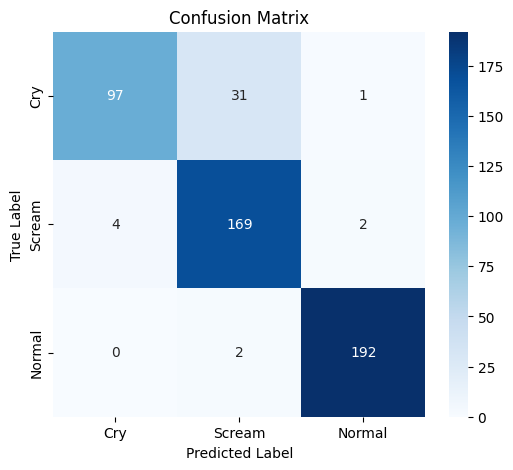

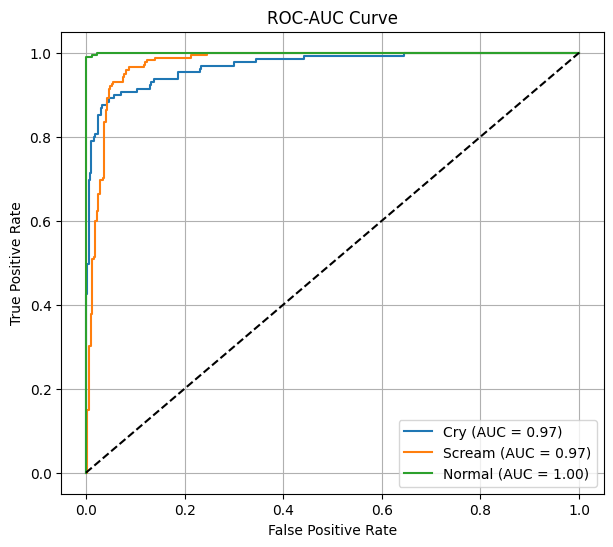

✅ Evaluation Completed!


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, TensorDataset

# ✅ Load model & test dataset
model.load_state_dict(torch.load("/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/best_model.pth"))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ Set model to evaluation mode
model.eval()
correct, total = 0, 0
test_preds, test_labels = [], []
test_probs = []  # Store softmax probabilities for ROC-AUC

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Forward pass
        outputs = model(batch_x)  # Logits
        probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        preds = outputs.argmax(dim=1)  # Get predicted class

        # Track metrics
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

        test_preds.extend(preds.cpu().numpy())  # Store predictions
        test_labels.extend(batch_y.cpu().numpy())  # Store true labels
        test_probs.extend(probs.cpu().numpy())  # Store softmax probabilities

# ✅ Compute final accuracy
test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")

# ✅ Convert lists to numpy arrays
test_preds = np.array(test_preds)  # Predicted labels
test_labels = np.array(test_labels)  # True labels
test_probs = np.array(test_probs)  # Probabilities (num_samples, num_classes)

# ✅ Print Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Cry", "Scream", "Normal"]))

# ✅ Generate & Plot Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Cry", "Scream", "Normal"], yticklabels=["Cry", "Scream", "Normal"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ✅ Convert labels to One-Hot Encoding for ROC-AUC Calculation
test_labels_bin = label_binarize(test_labels, classes=[0, 1, 2])  # Convert to one-hot format

# ✅ Plot ROC-AUC Curves
plt.figure(figsize=(7, 6))
for i, class_name in enumerate(["Cry", "Scream", "Normal"]):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], test_probs[:, i])  # Compute ROC curve
    roc_auc = auc(fpr, tpr)  # Compute AUC
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")  # Plot each class

# ✅ Final Plot Settings
plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid()
plt.show()

print("✅ Evaluation Completed!")


# Inferencing on Audio File

In [ ]:
import os
import librosa
import soundfile as sf
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub  # or your TF-based Wav2Vec2
import torch
import torch.nn as nn


In [ ]:
def preprocess_audio(input_path, output_path="temp_processed.wav", target_sr=16000):
    """
    Converts input audio to WAV (16kHz, 16-bit PCM, mono).
    If it's already valid, you could skip re-saving. Here we always ensure consistency.
    """
    # Load with librosa (auto-resamples if sr != None).
    y, sr = librosa.load(input_path, sr=None, mono=True)

    # If sample rate != target_sr, resample
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

    # Normalize to -1..1
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))

    # Save as 16-bit PCM WAV
    sf.write(output_path, y, target_sr, subtype="PCM_16")

    return output_path


In [ ]:
model_name = "facebook/wav2vec2-base-960h"
wav2vec2_model = Wav2Vec2Model.from_pretrained(model_name)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

wav2vec2_model.eval()      # Inference mode
wav2vec2_model.to("cpu")   # or "cuda" if you have a GPU

In [ ]:
def extract_wav2vec2_embedding(audio_path):
    """
    Loads audio at 16kHz, uses Wav2Vec2FeatureExtractor & Wav2Vec2Model to get (hidden_size,) embedding.
    """
    # 1) Load audio at 16kHz
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # 2) Convert waveform to Wav2Vec2 inputs
    inputs = feature_extractor(y, sampling_rate=16000, return_tensors="pt")

    # 3) Forward pass
    with torch.no_grad():
        outputs = wav2vec2_model(**inputs)  # last_hidden_state shape: (1, seq_len, hidden_size)

    # 4) Squeeze batch dimension => (seq_len, hidden_size)
    last_hidden = outputs.last_hidden_state.squeeze(0)

    # 5) Mean-pool over time => shape (hidden_size,)
    mean_emb = last_hidden.mean(dim=0).cpu().numpy()

    return mean_emb


In [ ]:
import torch.nn as nn

class FFNN(nn.Module):
    def __init__(self, input_dim=768, dropout_rate=0.3):
        """
        A feed-forward neural network with Dropout and BatchNorm for regularization.
        Adjust input_dim if your embeddings are not 768 in size.
        """
        super(FFNN, self).__init__()

        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(dropout_rate)

        self.fc5 = nn.Linear(128, 3)  # Output for 3 classes

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout4(x)

        x = self.fc5(x)  # Logits for classification
        return x


In [ ]:
# Load your trained weights
device = torch.device("cpu")  # or "cuda"
acoustic_classifier = FFNN(input_dim=768, dropout_rate=0.3).to(device)
acoustic_classifier.load_state_dict(torch.load("/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/best_model.pth", map_location=device))
acoustic_classifier.eval()

def classify_audio(input_audio_path):
    """
    1) Preprocess to 16kHz WAV
    2) Extract Wav2Vec2 embedding
    3) Pass embedding to PyTorch FFNN
    4) Print & return predicted label
    """
    # Step 1) Preprocess audio
    processed_path = preprocess_audio(input_audio_path, "temp_processed.wav")

    # Step 2) Extract Wav2Vec2 embedding => shape (768,)
    embedding = extract_wav2vec2_embedding(processed_path)

    # Convert to torch tensor => shape (1, 768)
    tensor_emb = torch.from_numpy(embedding).unsqueeze(0).float().to(device)

    # Step 3) Classify with FFNN
    with torch.no_grad():
        logits = acoustic_classifier(tensor_emb)  # shape (1, 3)
        pred_idx = torch.argmax(logits, dim=1).item()

    # Step 4) Map predicted index to label
    label_map = {0: "cry", 1: "scream", 2: "normal"}
    predicted_label = label_map[pred_idx]

    print(f"Predicted Class: {predicted_label}")
    return predicted_label


In [ ]:
audio_file = "/home/maditya/Desktop/Front Era/Model2 :- Wav2Vec2/Final_Dataset_with_aug/Cry/cry_002_aug.wav"
predicted_label = classify_audio(audio_file)


🔹 Predicted Class: cry
